<a href="https://colab.research.google.com/github/tony3ynot/Knowledge_Distillation_CIFAR-100/blob/main/Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation Implementation

- teacher model : ResNet-50
- student model : ResNet-18 (modified ver.)
- dataset : CIFAR-100




In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm.auto import tqdm

# 1. Load CIFAR-100 Dataset


In [2]:
BATCH_SIZE = 64
VAL_SPLIT_RATIO = 0.2

cifar100_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
    ])

cifar100_train_dataset = datasets.CIFAR100(root="./data/", train=True, download=True, transform=cifar100_transform)

num_train = len(cifar100_train_dataset)
indices = torch.randperm(num_train)

val_split = int(num_train * VAL_SPLIT_RATIO)
train_indices = indices[val_split:]
val_indices = indices[:val_split]

cifar100_val_dataset = torch.utils.data.Subset(cifar100_train_dataset, val_indices)
cifar100_train_dataset = torch.utils.data.Subset(cifar100_train_dataset, train_indices)

cifar100_train_loader = torch.utils.data.DataLoader(dataset=cifar100_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cifar100_val_loader = torch.utils.data.DataLoader(dataset=cifar100_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/


In [3]:
# Number of samples in the dataset

print("cifar100 train dataset size : ", len(cifar100_train_dataset))
print("cifar100 validation dataset size : ", len(cifar100_val_dataset))

cifar100 train dataset size :  40000
cifar100 validation dataset size :  10000


## CIFAR-100 Visualization

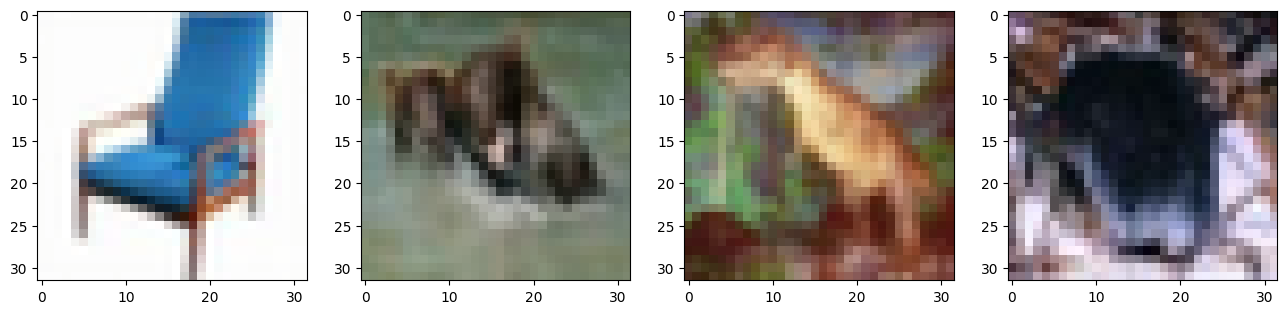

tensor([20,  3, 29, 74])


In [4]:
# Plot the training images and labels

cifar100_denormalize = transforms.Normalize(mean=[-0.507/0.267, -0.487/0.256, -0.441/0.276], std=[1/0.267, 1/0.256, 1/0.276])
to_pil_image = transforms.functional.to_pil_image

images, labels = next(iter(cifar100_train_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cifar100_denormalize(images[0])))
ax[1].imshow(to_pil_image(cifar100_denormalize(images[1])))
ax[2].imshow(to_pil_image(cifar100_denormalize(images[2])))
ax[3].imshow(to_pil_image(cifar100_denormalize(images[3])))
plt.show()

print(labels[:4])

# 2. Load Pretrained Model

Information of this pretrained model is here: https://huggingface.co/edadaltocg/resnet50_cifar100

In [6]:
!pip install detectors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [7]:
import detectors
import timm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

teacher = timm.create_model("resnet50_cifar100", pretrained=True)
teacher.to(device)
teacher.eval()

Downloading: "https://huggingface.co/edadaltocg/resnet50_cifar100/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/resnet50_cifar100.pth
100%|██████████| 90.7M/90.7M [00:03<00:00, 24.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequential(
    

# 3. Define the Student Model Architecture

For the student model, I will use ResNet18 (modified version for CIFAR10/100 dataset) since it is a simpler version of the given teacher model.

The implementation is based on the original paper.

In [8]:
## Resnet18
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, inner_channels, stride = 1, projection = None):
        super().__init__()

        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels * self.expansion, 3, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels))
        self.projection = projection
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        if self.projection is not None:
            shortcut = self.projection(x)
        else:
            shortcut = x

        out = self.relu(residual + shortcut)
        return out


class ResNet18(nn.Module):
    def __init__(self, block = BasicBlock, num_block_list = [2,2,2,2], num_classes = 100):
        super().__init__()

        self.in_channels = 64

        # slight change on the first conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.stage1 = self._make_stage(block, 64, num_block_list[0], stride=1)
        self.stage2 = self._make_stage(block, 128, num_block_list[1], stride=2)
        self.stage3 = self._make_stage(block, 256, num_block_list[2], stride=2)
        self.stage4 = self._make_stage(block, 512, num_block_list[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


    def _make_stage(self, block, inner_channels, num_blocks, stride=1):
        if stride != 1 or self.in_channels != inner_channels * block.expansion:
            projection = nn.Sequential(
                nn.Conv2d(self.in_channels, inner_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * block.expansion))
        else:
            projection = None

        layers = [block(self.in_channels, inner_channels, stride, projection)]
        self.in_channels = inner_channels * block.expansion

        for _ in range(1, num_blocks):
            layers += [block(self.in_channels, inner_channels)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

student_model = ResNet18()
student_model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (stage1): Sequential(
    (0): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=T

# 4. Implement the Distillation Process

loss function : KL Divergence Loss ( alpha = 0.3, temperature = 4 )

parameters :
- 50 epochs
- SGD ( lr = 0.1, momentum = 0.9, weight decay = 5e-4 )
- Step LR scheduler (step size = 20, gamma = 0.1)

result :
- validation data accuracy = 64.85 %
- training time = 2 hrs

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Knowledge distillation loss
def knowledge_distillation_loss(student_logits, labels, teacher_logits, alpha = 0.3, T = 4):
        hard_loss = F.cross_entropy(input=student_logits, target=labels)
        soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_logits/T, dim=1), F.softmax(teacher_logits/T, dim=1)) * (T ** 2)
        total_loss =  alpha * hard_loss + (1-alpha) * soft_loss
        return total_loss

epochs = 50
optimizer = torch.optim.SGD(student_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(epochs):
    n_iter = 0
    loss_total = 0
    acc_total = 0
    for i, data in enumerate(tqdm(cifar100_train_loader)):
        inputs, targets = data[0].to(device), data[1].to(device)
        teacher_output = teacher(inputs)
        student_output = student_model(inputs)

        optimizer.zero_grad()
        loss = knowledge_distillation_loss(student_output, targets, teacher_output)
        loss.backward()
        optimizer.step()

        pred = student_output.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0]
        loss_total += loss.item()
        acc_total += acc
        n_iter += 1

    scheduler.step()
    print(f"Epoch: {epoch+1} - Loss: {loss_total/n_iter:.3f} - Acc: {acc_total/n_iter:.3f}")

print('Finished Training')

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1 - Loss: 6.253 - Acc: 0.100


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2 - Loss: 5.372 - Acc: 0.224


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3 - Loss: 4.505 - Acc: 0.345


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4 - Loss: 3.910 - Acc: 0.435


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5 - Loss: 3.526 - Acc: 0.492


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6 - Loss: 3.233 - Acc: 0.541


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7 - Loss: 2.975 - Acc: 0.584


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 8 - Loss: 2.781 - Acc: 0.615


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 9 - Loss: 2.604 - Acc: 0.644


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10 - Loss: 2.485 - Acc: 0.665


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 11 - Loss: 2.351 - Acc: 0.688


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 12 - Loss: 2.249 - Acc: 0.705


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 13 - Loss: 2.180 - Acc: 0.718


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 14 - Loss: 2.103 - Acc: 0.731


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 15 - Loss: 2.041 - Acc: 0.742


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 16 - Loss: 2.017 - Acc: 0.745


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 17 - Loss: 1.940 - Acc: 0.759


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 18 - Loss: 1.938 - Acc: 0.758


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 19 - Loss: 1.887 - Acc: 0.769


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 20 - Loss: 1.884 - Acc: 0.769


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 21 - Loss: 0.957 - Acc: 0.924


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 22 - Loss: 0.567 - Acc: 0.976


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 23 - Loss: 0.422 - Acc: 0.989


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 24 - Loss: 0.342 - Acc: 0.994


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 25 - Loss: 0.291 - Acc: 0.997


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 26 - Loss: 0.259 - Acc: 0.998


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 27 - Loss: 0.237 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 28 - Loss: 0.222 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 29 - Loss: 0.208 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 30 - Loss: 0.200 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 31 - Loss: 0.193 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 32 - Loss: 0.186 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 33 - Loss: 0.179 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 34 - Loss: 0.176 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 35 - Loss: 0.171 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 36 - Loss: 0.167 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 37 - Loss: 0.163 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 38 - Loss: 0.157 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 39 - Loss: 0.154 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 40 - Loss: 0.152 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 41 - Loss: 0.139 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 42 - Loss: 0.133 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 43 - Loss: 0.128 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 44 - Loss: 0.125 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 45 - Loss: 0.123 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 46 - Loss: 0.120 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 47 - Loss: 0.118 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 48 - Loss: 0.117 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 49 - Loss: 0.116 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 50 - Loss: 0.114 - Acc: 1.000
Finished Training


# 5. Evaluate the network on the validation data

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in cifar100_val_loader:
        images, labels = data
        outputs = student_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 validation images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 validation images: 64.85 %


# 6. Comparison with pure student model training (w/o knowledge distillation)



loss function : Cross Entropy Loss

parameters (same settings):
- 50 epochs
- SGD ( lr = 0.1, momentum = 0.9, weight decay = 5e-4 )
- Step LR scheduler (step size = 20, gamma = 0.1)

result:
- validation data accuracy = 58.45 % (-6.4 %p)
- training time = 30 min

In [ ]:
student_model = ResNet18()
student_model.to(device)

In [9]:
epochs = 50
optimizer = torch.optim.SGD(student_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    n_iter = 0
    loss_total = 0
    acc_total = 0
    for i, data in enumerate(tqdm(cifar100_train_loader)):
        inputs, targets = data[0].to(device), data[1].to(device)
        output = student_model(inputs)

        optimizer.zero_grad()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0]
        loss_total += loss.item()
        acc_total += acc
        n_iter += 1

    scheduler.step()
    print(f"Epoch: {epoch+1} - Loss: {loss_total/n_iter:.3f} - Acc: {acc_total/n_iter:.3f}")

print('Finished Training')

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1 - Loss: 4.019 - Acc: 0.081


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2 - Loss: 3.363 - Acc: 0.180


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3 - Loss: 2.867 - Acc: 0.275


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4 - Loss: 2.420 - Acc: 0.362


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5 - Loss: 2.099 - Acc: 0.432


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6 - Loss: 1.878 - Acc: 0.480


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7 - Loss: 1.725 - Acc: 0.517


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 8 - Loss: 1.593 - Acc: 0.547


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 9 - Loss: 1.478 - Acc: 0.579


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10 - Loss: 1.392 - Acc: 0.600


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 11 - Loss: 1.311 - Acc: 0.621


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 12 - Loss: 1.242 - Acc: 0.638


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 13 - Loss: 1.198 - Acc: 0.649


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 14 - Loss: 1.159 - Acc: 0.663


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 15 - Loss: 1.116 - Acc: 0.674


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 16 - Loss: 1.085 - Acc: 0.681


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 17 - Loss: 1.042 - Acc: 0.695


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 18 - Loss: 1.034 - Acc: 0.697


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 19 - Loss: 1.003 - Acc: 0.706


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 20 - Loss: 0.991 - Acc: 0.708


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 21 - Loss: 0.337 - Acc: 0.912


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 22 - Loss: 0.113 - Acc: 0.982


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 23 - Loss: 0.059 - Acc: 0.995


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 24 - Loss: 0.037 - Acc: 0.998


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 25 - Loss: 0.028 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 26 - Loss: 0.022 - Acc: 0.999


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 27 - Loss: 0.019 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 28 - Loss: 0.017 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 29 - Loss: 0.016 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 30 - Loss: 0.015 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 31 - Loss: 0.015 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 32 - Loss: 0.014 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 33 - Loss: 0.014 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 34 - Loss: 0.013 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 35 - Loss: 0.013 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 36 - Loss: 0.013 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 37 - Loss: 0.013 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 38 - Loss: 0.012 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 39 - Loss: 0.012 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 40 - Loss: 0.012 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 41 - Loss: 0.011 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 42 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 43 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 44 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 45 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 46 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 47 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 48 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 49 - Loss: 0.010 - Acc: 1.000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 50 - Loss: 0.010 - Acc: 1.000
Finished Training


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in cifar100_val_loader:
        images, labels = data
        outputs = student_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 validation images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 validation images: 58.45 %
